In [1]:
import numpy as np
import pymc3 as pm

import scipy.stats as st

import aesara.tensor as at

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"
%matplotlib inline

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
K = 20; M = 5; mu = 2.
rng = np.random.RandomState(seed=34)

y_8 = rng.normal(loc=mu, scale=2., size=[8,])
y_50 = rng.normal(loc=mu, scale=2., size=[50,])

In [3]:
def stick_breaking(betas):
    """
    betas ~ Beta(1, alpha)
    """
    sticks = at.concatenate(
        [
            [1],
            at.cumprod(1 - betas[:-1])
        ],
    )
    
    product = at.mul(betas, sticks)
    
    return at.concatenate(
        [
            product,
            [1 - at.sum(product)],
        ]
    )

In [4]:
def run_inference(y_obs):
    with pm.Model() as model:

        concentration = pm.InverseGamma("concentration", alpha=1, beta=1)

        betas = pm.Beta("betas", 1., concentration + len(y_obs), shape=(K,))
        weights = pm.Deterministic("weights", stick_breaking(betas))

        G0 = pm.Normal(name="G0", mu=0., sigma=3.)

        mixture_idx = pm.Bernoulli(name="mixture-idx", p=at.mul(concentration, at.inv(concentration + len(y_obs))))

        cat_idx = pm.Categorical(name="cat-idx", p=np.ones_like(y_obs)/len(y_obs), shape=(K+1,))

        # should include y as observed keyword instead of this?
        cat_sample = pm.Deterministic(
            name="cat-sample",
            var=at.as_tensor_variable(y_obs)[cat_idx],
        )

        dp_post = pm.Deterministic(
            name="dp-post",
            var=mixture_idx*G0 + (1 - mixture_idx)*cat_sample,
        )

        """
        prior should give DP prior and pm.sample should give posterior...
        right now, I am obtaining a posterior DP (atoms and weights) from prior below
        """
        prior = pm.sample_prior_predictive(samples=1234,)
        posterior = pm.sample(draws=1234, chains=1)
        
    return prior, posterior

In [5]:
x_plot = np.linspace(-4, 8, num=1001)

def cdf(alpha, y_obs):
    
    prior, mcmc_samples = run_inference(y_obs)
    
    w = mcmc_samples.to_dict()["posterior"]["weights"][0]
    m = mcmc_samples.to_dict()["posterior"]["dp-post"][0]

    dirac = np.less.outer(m, x_plot).astype(int)
    
    return mcmc_samples, (w[..., np.newaxis]*dirac).sum(axis=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [concentration, betas, G0]
>BinaryGibbsMetropolis: [mixture-idx]
>CategoricalGibbsMetropolis: [cat-idx]


Sampling 1 chain for 1_000 tune and 1_234 draw iterations (1_000 + 1_234 draws total) took 12 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [concentration, betas, G0]
>BinaryGibbsMetropolis: [mixture-idx]
>CategoricalGibbsMetropolis: [cat-idx]


Sampling 1 chain for 1_000 tune and 1_234 draw iterations (1_000 + 1_234 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


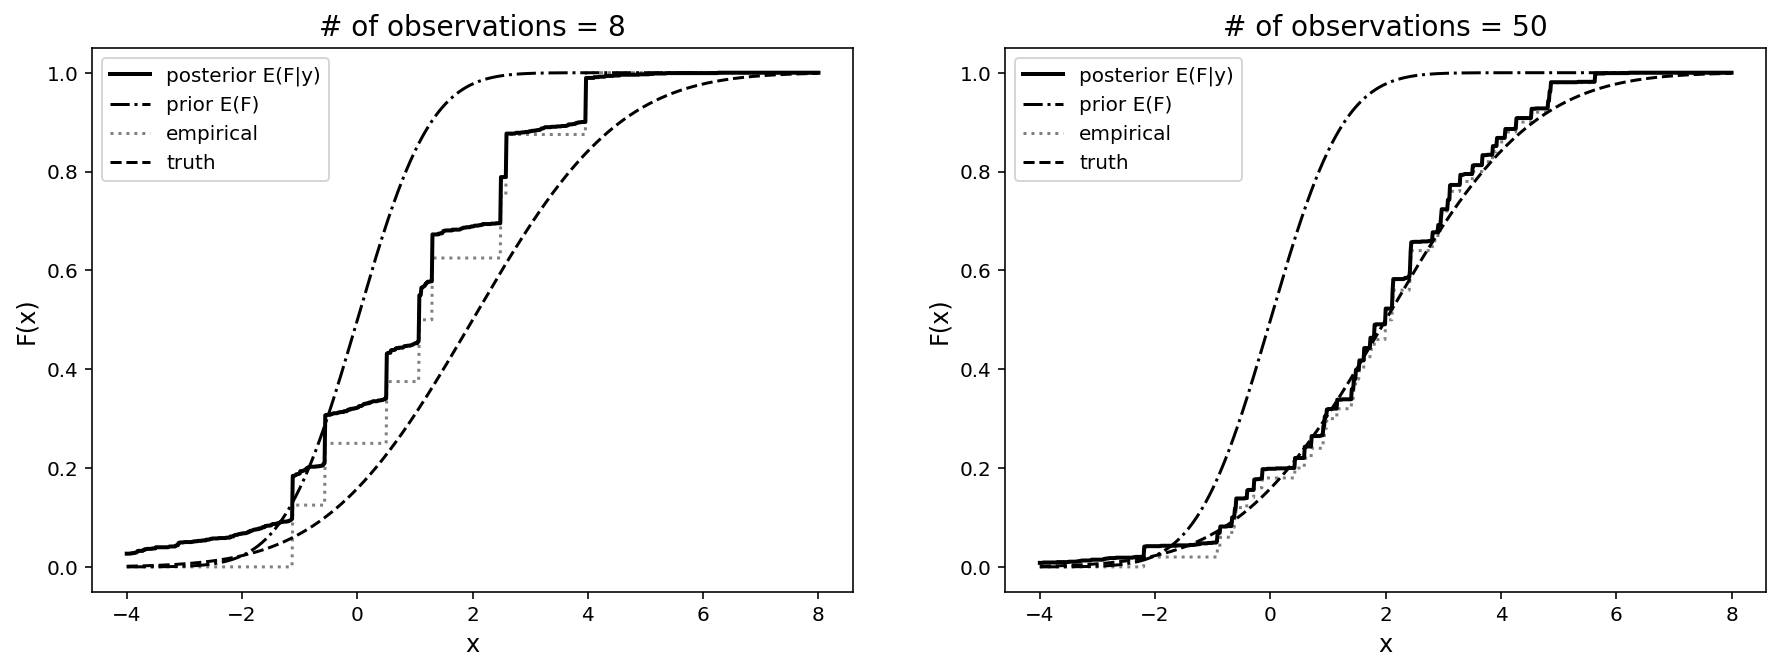

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# for i in range(N):
#     ax.plot(x_plot, dp_sample[i], c="k", alpha=0.1)

for fig_num in range(2):
    
    if fig_num == 0:
        y_obs = y_8
        n_obs = 8
    elif fig_num == 1:
        y_obs = y_50
        n_obs = 50
        
    mcmc_samples, dp_sample = cdf(5, y_obs)
    
    _ = ax[fig_num].plot(x_plot, dp_sample.mean(axis=0), c="k", linestyle="-", linewidth=2, label="posterior E(F|y)")
    _ = ax[fig_num].plot(x_plot, st.norm.cdf(x_plot), c="k", linestyle="-.", label="prior E(F)")
    _ = ax[fig_num].plot(x_plot, np.greater.outer(x_plot, y_obs).mean(axis=1), c="k", linestyle="dotted", alpha=0.5, label="empirical")
    _ = ax[fig_num].plot(x_plot, st.norm.cdf(x_plot, loc=2., scale=2.), c="k", linestyle="--", label="truth")
    
    _ = ax[fig_num].set_title(f"# of observations = {n_obs}", fontsize=14)
    _ = ax[fig_num].set_ylabel("F(x)", fontsize=12)
    _ = ax[fig_num].set_xlabel("x", fontsize=12)
    _ = ax[fig_num].legend()

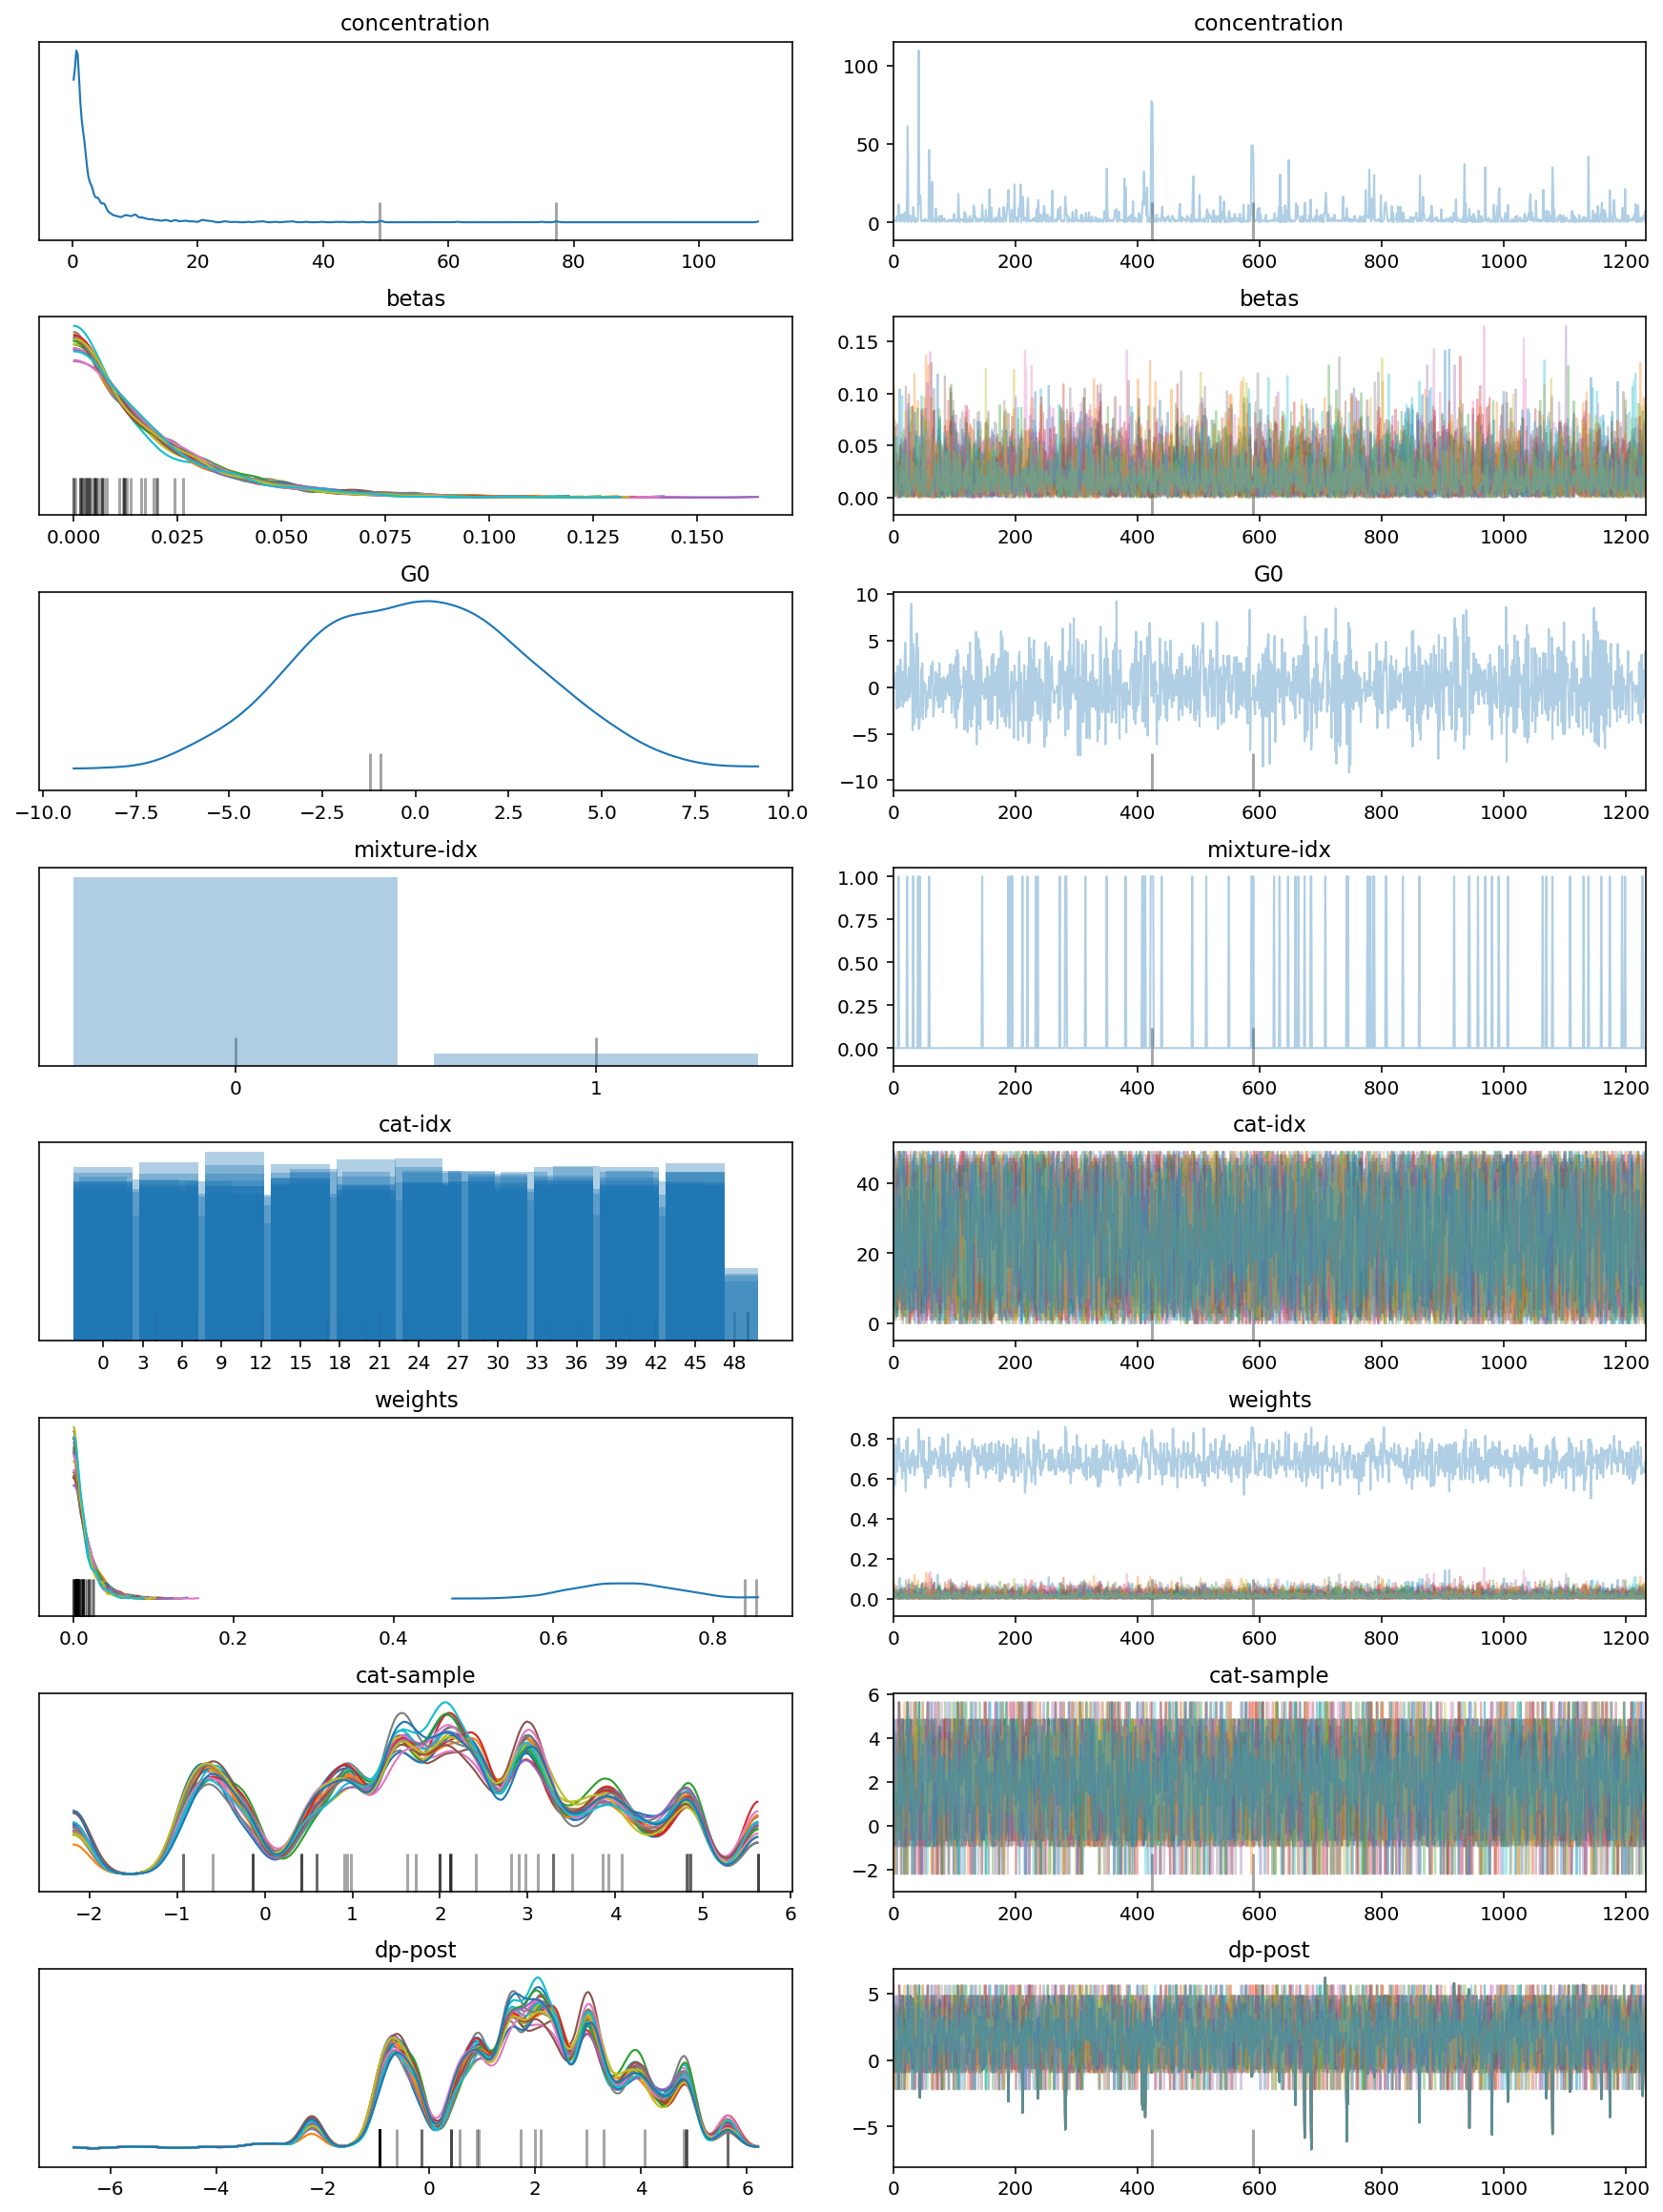

In [7]:
_ = pm.plot_trace(mcmc_samples)